In [79]:
import os
import sys
import csv
import textwrap


sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from utils.checkpoint import load_params

from model.train.recommender import optimize_users

#### Load Embeddings

In [2]:
params = load_params("../artifacts/model/32m_users_training_features_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [3]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [4]:
params = load_params("../artifacts/model/32m_users_training_20.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

#### Load Data

In [5]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, _ = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id

#### Movie Embedding Space

In [6]:
idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

In [73]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings" in idx_to_title[x].lower())
            or ("fifty shades" in idx_to_title[x].lower())
            or ("despicable me" in idx_to_title[x].lower())
            or ("hotel transylvania" in idx_to_title[x].lower())
        ),
        range(len(movie_user))
    )
)

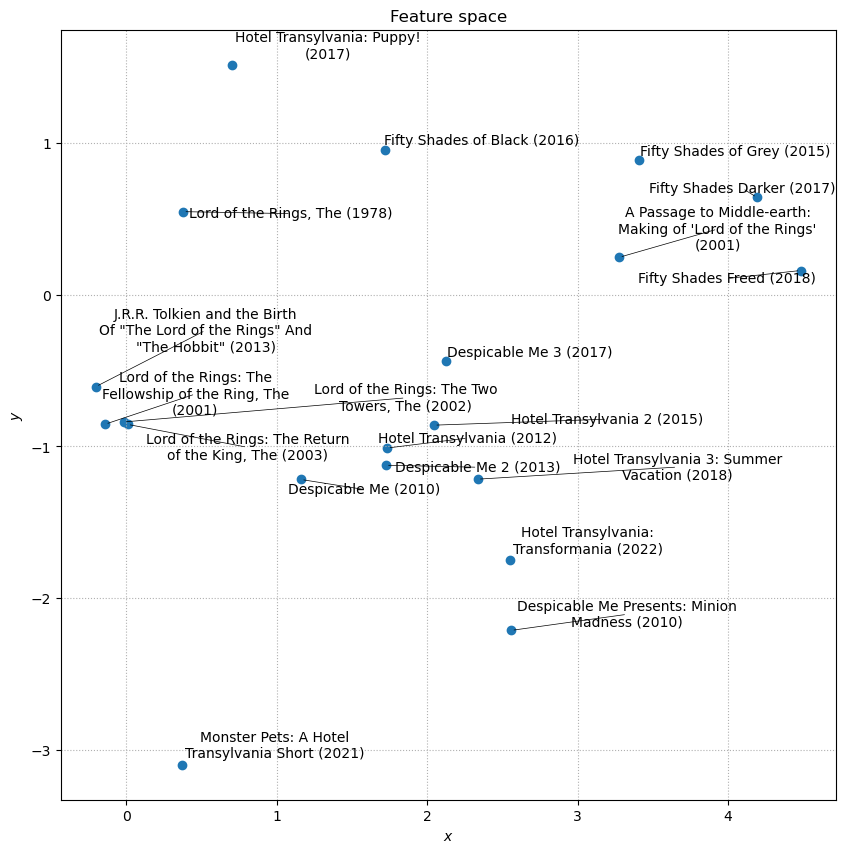

In [80]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.svg", format="svg")
plt.show()

#### Feature Embedding Space

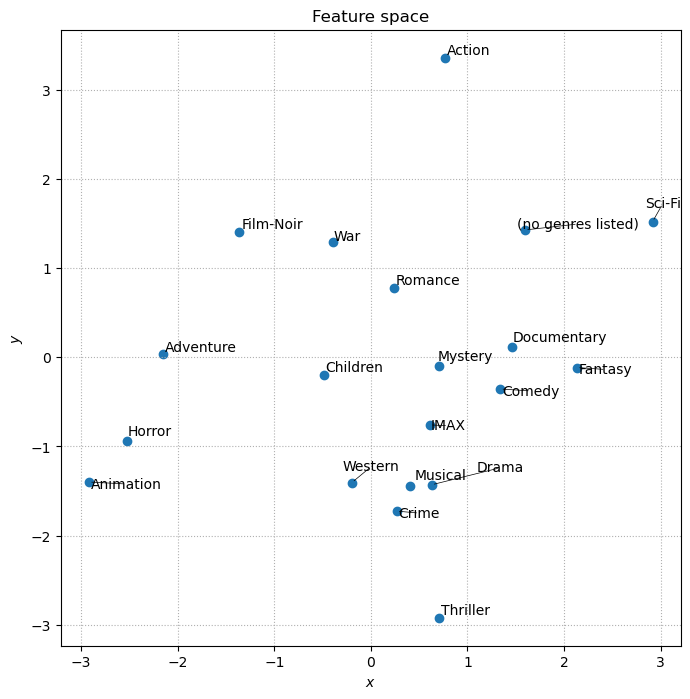

In [81]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.svg", format="svg")
plt.show()

#### Dummy User Embedding

In [10]:
lord_of_the_ring_idx = movie_id_to_idx[title_to_movie_id["Lord of the Rings: The Fellowship of the Ring, The (2001)"]]
lord_of_the_ring_rating = 5.0

dummy_id = "dummy"
dummy_idx = len(user_id_to_idx)
user_id_to_idx[dummy_id] = dummy_idx
idx_to_user_id.append(dummy_id)

user_movie.append((
    [lord_of_the_ring_idx], [lord_of_the_ring_rating]
))

movie_user[lord_of_the_ring_idx][0].append(dummy_idx)
movie_user[lord_of_the_ring_idx][1].append(lord_of_the_ring_rating)

user_embeddings = np.vstack([user_embeddings, np.random.normal(0, np.sqrt(user_embeddings.shape[1]), (user_embeddings.shape[1]))])
user_bias = np.hstack([user_bias, np.random.randn()])

assert len(user_embeddings) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"

In [11]:
for i in range(len(user_movie)):
    user_movie[i] = (
        np.array(user_movie[i][0], dtype=int),
        np.array(user_movie[i][1], dtype=np.float64),
    )

for i in range(len(movie_user)):
    movie_user[i] = (
        np.array(movie_user[i][0], dtype=int),
        np.array(movie_user[i][1], dtype=np.float64),
    )

In [15]:
old_embedding = user_embeddings[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias,
        movie_bias,
        user_embeddings[dummy_idx, np.newaxis],
        movie_embeddings
    )

assert ((old_embedding - user_embeddings[dummy_idx]) > 1e-2).any(), "Embedding not updated"

#### Top 10 Prediction for Dummy User

In [16]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title)

Top 10 Prediction
1 - Winx Club: The Secret of the Lost Kingdom (2007)
2 - Unseen Enemy (2017)
3 - Happiness Continues (2020)
4 - Hitler (1962)
5 - La stranezza (2022)
6 - Just Me and You (2019)
7 - Circle of Pain (2010)
8 - La Cenerentola (1981)
9 - The Long Wait (1954)
10 - Vinaro Bhagyamu Vishnu Katha (2023)


In [17]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title)

Top 10 Prediction [downplayed bias]
1 - Happiness Continues (2020)
2 - More Than Chance (2010)
3 - Circle of Pain (2010)
4 - You'll Only Have Each Other (2018)
5 - Just Me and You (2019)
6 - La stranezza (2022)
7 - Odysseus & the Isle of Mists (2008)
8 - Most Eligible Bachelor (2021)
9 - Black Hole (2018)
10 - Emanuelle and the Girls of Madame Claude (La via della prostituzione) (1978)


In [18]:
less_than_100_rating = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in less_than_100_rating:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title)
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Lord of the Rings: The Return of the King, The (2003)
2 - Lord of the Rings: The Two Towers, The (2002)
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)
4 - Hobbit: An Unexpected Journey, The (2012)
5 - Hobbit: The Desolation of Smaug, The (2013)
6 - The Hobbit: The Battle of the Five Armies (2014)
7 - Men with Brooms (2002)
8 - Harry Potter and the Half-Blood Prince (2009)
9 - Harry Potter and the Deathly Hallows: Part 2 (2011)
10 - Harry Potter and the Order of the Phoenix (2007)


#### Top Polarizing Movies

In [82]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm")

for i, idx in enumerate(reversed(movie_embedding_norm[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title)

Top 20 Movie by embedding norm
1 - Most Eligible Bachelor (2021)
2 - The Pencil (2019)
3 - Upstairs and Downstairs (1959)
4 - The Wrong Woman (2013)
5 - Faith (2019)
6 - Ammar (2020)
7 - Straight Men & the Men Who Love Them (2005)
8 - Jena Friedman: American Cunt (2016)
9 - Shamshera (2022)
10 - Daddy's Girl (2018)
11 - Christmas in Vienna (2020)
12 - Toy Gun (2018)
13 - The Rabbit Is Me (1965)
14 - Don't Pass Me By (2013)
15 - 'Neath Brooklyn Bridge (1942)
16 - 1966-1988: Kieslowski, Polish Filmmaker (2005)
17 - Aboli's Journey (2021)
18 - Loneliness in the Net (2006)
19 - One More Dream (2022)
20 - God's Compass (2016)


In [83]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Top 20 Movie by embedding norm [cosine similarity filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break  

    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title)
        i += 1
        movie_bag.append(idx)

Top 20 Movie by embedding norm [cosine similarity filtering]
1 - Most Eligible Bachelor (2021)
2 - The Pencil (2019)
3 - Upstairs and Downstairs (1959)
4 - The Wrong Woman (2013)
5 - Faith (2019)
6 - Ammar (2020)
7 - Straight Men & the Men Who Love Them (2005)
8 - Jena Friedman: American Cunt (2016)
9 - Shamshera (2022)
10 - Daddy's Girl (2018)
11 - Christmas in Vienna (2020)
12 - Toy Gun (2018)
13 - The Rabbit Is Me (1965)
14 - Don't Pass Me By (2013)
15 - 'Neath Brooklyn Bridge (1942)
16 - 1966-1988: Kieslowski, Polish Filmmaker (2005)
17 - Aboli's Journey (2021)
18 - Loneliness in the Net (2006)
19 - One More Dream (2022)
20 - God's Compass (2016)


---